# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [56]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


In [57]:
img_rows, img_cols = 28, 28
nb_classes = 10

def concatenate_digits(startIndex, length, data, axis):
    return np.concatenate(data[startIndex:startIndex + length], axis=axis)

def concatenate_sliding_window(data, length, axis):
    return np.array([concatenate_digits(i, length, data, axis) for i in range(data.shape[0] - length)])


In [59]:
def getTrainData(length):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = concatenate_sliding_window(X_train, length, 1)
    X_test = concatenate_sliding_window(X_test, length, 1)

    print (X_train.shape, X_test.shape)
    X_train = X_train.reshape(X_train.shape[0], img_rows, X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, X_test.shape[2], 1)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    
    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    Y_train = concatenate_sliding_window(Y_train, length, 0)
    Y_test = concatenate_sliding_window(Y_test, length, 0)

    return (X_train, Y_train), (X_test, Y_test ), input_shape


In [72]:
import matplotlib.pyplot as plt
def display_digit(start, length, data):
    print (data.shape)
    print (data[start].shape)
    print (length)
    #np.concatenate((a,b), axis=1)
#    y_display = np.concatenate((Y_train[num], Y_train[num+1]), axis=0)
#    print(y_display)
    
#    print (X_train[num].shape)
#    x_display = np.concatenate((X_train[num], X_train[num+1]), axis=1)
#    print (x_display.shape)
    
    #combinedDigits = concatenate_digits(start, length, data, 1)

#    label = y_display.argmax(axis=0)
    #image = combinedDigits.reshape([28, 28 * length])
    image = data[start].reshape([28, 28 * length])
#    plt.title('Example: %d  Label: %d' % (start, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

In [60]:
def train(Xtrain, yTrain, XTest, yTest, inpShape):
    print('X_train shape:', Xtrain.shape)
    print('Y_train shape:', y_train.shape)
    
    batch_size = 128
    nb_epoch = 12
    nb_filters = 32
    pool_size = (2, 2)
    kernel_size = (3, 3)

    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='valid', input_shape=inpShape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(yTrain.shape[1]))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    model.fit(Xtrain, yTrain, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(XTest, yTest))
    score = model.evaluate(XTest, yTest, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])


In [76]:
def train_model1(Xtrain, yTrain, XTest, yTest, inpShape, nb_epoch):
    print('X_train shape:', Xtrain.shape)
    print('Y_train shape:', y_train.shape)
    print('yTest shape:', yTest.shape)
    
    batch_size = 128
    nb_filters = 32
    pool_size = (2, 2)
    kernel_size = (3, 3)

    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='valid', input_shape=inpShape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(yTrain.shape[1]))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    model.fit(Xtrain, yTrain, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(XTest, yTest))
    score = model.evaluate(XTest, yTest, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    predictions = model.predict(XTest[0:10])
    for i in range(0,10):
        display_digit(i, yTest.shape[1]/10, XTest)
        print(predictions[i])
        



(59995, 28, 140) (9995, 28, 140)
(59995, 28, 140, 1)
(28, 140, 1)


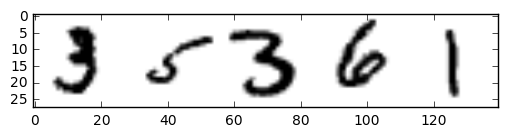

X_train shape: (59995, 28, 140, 1)
Y_train shape: (59995, 50)
Train on 59995 samples, validate on 9995 samples
Epoch 1/2
59995/59995 [==============================] - 897s - loss: 14.1822 - acc: 0.1763 - val_loss: 11.2489 - val_acc: 0.2283
Epoch 2/2
59995/59995 [==============================] - 821s - loss: 12.5535 - acc: 0.1960 - val_loss: 10.4806 - val_acc: 0.2181
Test score: 10.4805787222
Test accuracy: 0.21810905453


In [67]:

nb_digits = 5
nb_epoch = 2
(X_train, y_train), (X_test, y_test), input_shape = getTrainData(nb_digits)
display_digit(10, nb_digits, X_train)
train_model1(X_train, y_train, X_test, y_test, input_shape, nb_epoch)

(59997, 28, 84, 1)
(28, 84, 1)
3


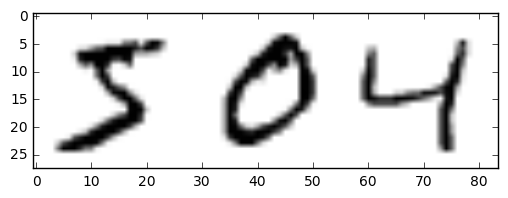

(59997, 30)
(30,)
3


ValueError: total size of new array must be unchanged

In [91]:
display_digit(0, 3, X_train)
display_digit(0, 3, y_train)

(59995, 28, 140) (9995, 28, 140)
(59995, 28, 140, 1)
(28, 140, 1)


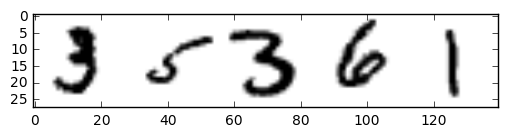

X_train shape: (59995, 28, 140, 1)
Y_train shape: (59995, 50)
Train on 59995 samples, validate on 9995 samples
Epoch 1/100
59995/59995 [==============================] - 829s - loss: 14.1756 - acc: 0.1715 - val_loss: 11.0854 - val_acc: 0.2027
Epoch 2/100
59995/59995 [==============================] - 823s - loss: 12.5488 - acc: 0.1936 - val_loss: 10.5330 - val_acc: 0.1873
Epoch 3/100
59995/59995 [==============================] - 744s - loss: 12.0909 - acc: 0.1943 - val_loss: 10.2862 - val_acc: 0.1800
Epoch 4/100
59995/59995 [==============================] - 735s - loss: 11.7523 - acc: 0.1943 - val_loss: 9.9523 - val_acc: 0.2008
Epoch 5/100
59995/59995 [==============================] - 730s - loss: 11.4523 - acc: 0.1943 - val_loss: 9.8106 - val_acc: 0.2024
Epoch 6/100
59995/59995 [==============================] - 731s - loss: 11.1593 - acc: 0.1941 - val_loss: 9.5946 - val_acc: 0.2046
Epoch 7/100
59995/59995 [==============================] - 730s - loss: 10.8620 - acc: 0.1951 - val_

In [68]:
nb_digits = 5
nb_epoch = 100
(X_train, y_train), (X_test, y_test), input_shape = getTrainData(nb_digits)
display_digit(10, nb_digits, X_train)
train_model1(X_train, y_train, X_test, y_test, input_shape, nb_epoch)
# Did not have the predict and display

(59997, 28, 84) (9997, 28, 84)
X_train shape: (59997, 28, 84, 1)
Y_train shape: (59997, 30)
yTest shape: (9997, 30)
Train on 59997 samples, validate on 9997 samples
Epoch 1/30
59997/59997 [==============================] - 501s - loss: 6.1122 - acc: 0.2999 - val_loss: 4.4749 - val_acc: 0.3216
Epoch 2/30
59997/59997 [==============================] - 501s - loss: 5.0864 - acc: 0.3222 - val_loss: 4.1655 - val_acc: 0.3516
Epoch 3/30
59997/59997 [==============================] - 460s - loss: 4.7586 - acc: 0.3237 - val_loss: 3.9940 - val_acc: 0.3566
Epoch 4/30
59997/59997 [==============================] - 494s - loss: 4.5085 - acc: 0.3257 - val_loss: 3.8671 - val_acc: 0.3563
Epoch 5/30
59997/59997 [==============================] - 487s - loss: 4.3107 - acc: 0.3268 - val_loss: 3.7879 - val_acc: 0.3538
Epoch 6/30
59997/59997 [==============================] - 467s - loss: 4.1610 - acc: 0.3274 - val_loss: 3.7160 - val_acc: 0.3314
Epoch 7/30
59997/59997 [==============================] - 450

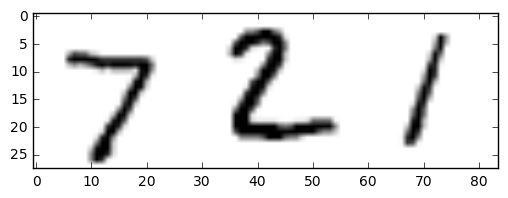

[  6.54212158e-07   8.24181427e-07   3.69050467e-05   5.63146023e-05
   5.23652020e-08   7.94720791e-07   1.50408876e-08   2.89610714e-01
   1.62659796e-06   8.07566835e-07   1.37485063e-03   1.24687358e-05
   3.64672691e-01   4.03454493e-07   2.14648477e-08   2.40786786e-08
   1.54678011e-03   2.47848617e-11   5.81101085e-06   1.28628896e-09
   1.32348585e-08   3.42575043e-01   3.30710428e-08   1.16336487e-07
   8.19421839e-05   5.97229715e-08   1.78225832e-06   1.15731091e-05
   7.14987834e-07   7.10017684e-06]
(9997, 28, 84, 1)
(28, 84, 1)
3


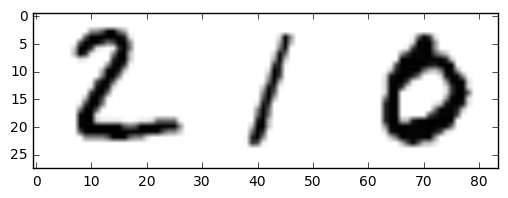

[  1.98614527e-03   6.03991657e-06   3.11715126e-01   2.25119857e-05
   1.25707936e-06   1.49253390e-06   1.62314609e-04   1.86402769e-08
   1.17265461e-06   7.71539543e-09   1.16795150e-06   3.46987695e-01
   2.78019852e-05   4.89019612e-06   5.19137830e-04   8.55038536e-07
   8.88559043e-06   1.23071368e-05   9.52191658e-06   4.68997860e-06
   3.37012887e-01   2.63445145e-05   1.19543547e-04   3.97086442e-05
   4.44085708e-06   2.66965235e-05   1.13231223e-03   7.73624852e-05
   1.49292191e-05   7.27822771e-05]
(9997, 28, 84, 1)
(28, 84, 1)
3


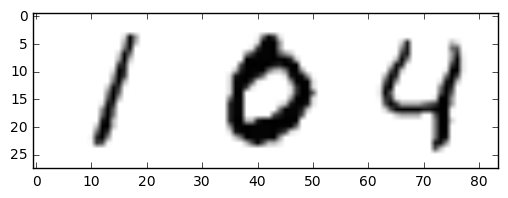

[  5.32840374e-07   3.31238836e-01   6.24774330e-08   5.62900027e-07
   3.80200036e-05   4.42743527e-07   2.27674121e-07   5.21913789e-05
   1.34689810e-06   1.55806197e-06   3.54852825e-01   1.76490769e-08
   8.83552821e-06   2.80543964e-06   5.66508788e-07   7.01148338e-06
   9.88674365e-05   1.70148382e-07   7.35839194e-06   2.91223137e-06
   1.90410265e-08   9.70248948e-09   8.32474939e-07   4.85581575e-09
   3.13274950e-01   6.31988559e-11   1.56746740e-08   9.12754103e-08
   5.55844053e-07   4.08384774e-04]
(9997, 28, 84, 1)
(28, 84, 1)
3


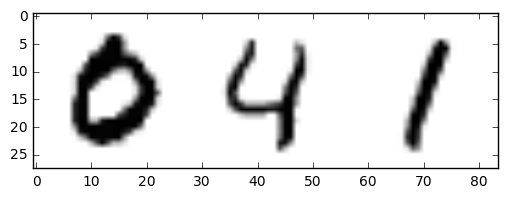

[  3.32404226e-01   8.35624476e-08   1.74295365e-05   1.83879831e-06
   2.57823949e-08   1.63356242e-06   3.43627471e-06   5.54446693e-08
   9.12452776e-07   2.55317048e-07   4.74370268e-07   1.36383465e-08
   3.52303395e-08   2.85192474e-08   3.26187491e-01   3.77193636e-08
   3.66686415e-08   1.48681520e-08   4.05669908e-07   1.85795834e-05
   3.38721406e-09   3.41358602e-01   1.27816895e-06   7.09695724e-09
   1.28111867e-06   4.05444389e-09   1.04993525e-08   1.70234034e-06
   4.62210821e-08   1.43042920e-08]
(9997, 28, 84, 1)
(28, 84, 1)
3


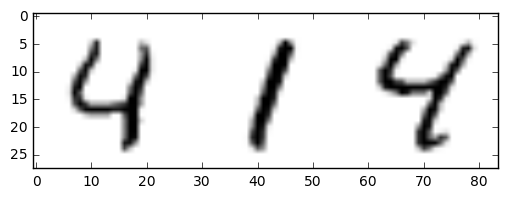

[  5.35162048e-09   2.40023212e-07   4.38398438e-08   9.99554550e-10
   3.81265759e-01   9.52771106e-09   7.60103447e-08   5.78866207e-07
   2.24899992e-07   3.34568060e-04   8.40522176e-08   3.28475177e-01
   2.00394607e-06   2.15365418e-07   2.76160717e-05   2.61201507e-07
   1.75042339e-06   5.40509234e-07   1.44765625e-06   9.59790185e-08
   3.76454551e-07   1.36419226e-06   1.32652985e-06   8.78280275e-08
   2.86746055e-01   2.10560938e-05   2.97039350e-07   1.06672145e-04
   1.34635239e-03   1.66567590e-03]
(9997, 28, 84, 1)
(28, 84, 1)
3


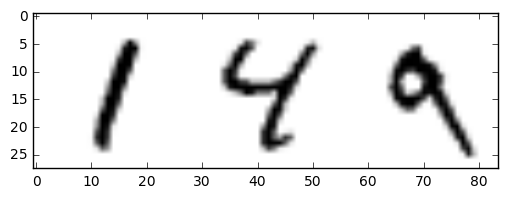

[  6.99636303e-07   3.55553657e-01   8.94868947e-07   2.63839728e-09
   6.82707541e-05   1.75562752e-06   8.94696132e-06   4.51926026e-05
   4.84984582e-07   1.50350070e-06   1.67792962e-07   7.60768817e-05
   2.32360958e-06   2.45483051e-07   3.69231761e-01   3.53819541e-06
   8.33380091e-06   1.21672110e-06   2.03592982e-03   1.09842280e-04
   6.40128022e-08   2.60030106e-07   1.70880139e-05   6.34478738e-06
   2.26475601e-03   2.78622338e-06   1.92607629e-07   7.85143948e-06
   6.11027426e-05   2.70488769e-01]
(9997, 28, 84, 1)
(28, 84, 1)
3


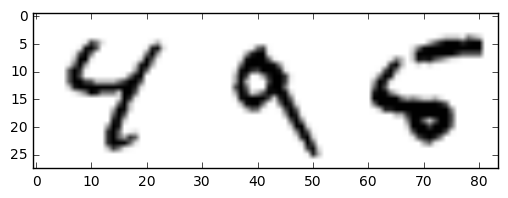

[  5.36945812e-08   1.62215598e-04   8.12113932e-09   2.34462885e-08
   4.04586077e-01   2.57399079e-04   1.67869052e-06   9.56028998e-06
   2.87953648e-03   6.89660991e-03   8.05363072e-07   3.51141182e-07
   1.64626108e-04   5.13790292e-04   1.53980695e-03   1.66568410e-04
   2.61275691e-05   6.01945612e-05   2.97771627e-03   4.85683441e-01
   3.81857644e-05   2.83020203e-08   1.38682230e-06   2.06333539e-07
   2.39944184e-05   9.13544297e-02   1.51614042e-03   4.93344487e-07
   1.11432548e-03   2.43418908e-05]
(9997, 28, 84, 1)
(28, 84, 1)
3


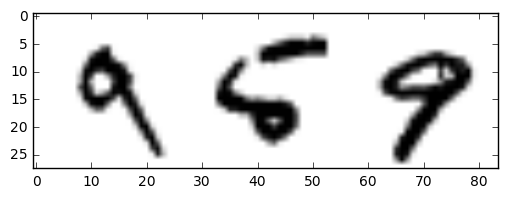

[  6.47142873e-09   3.18248294e-06   1.98191401e-08   3.82835964e-07
   2.56041232e-02   7.62721538e-05   6.18859076e-06   1.26957832e-06
   4.11856500e-03   2.92074651e-01   1.14871124e-04   3.15956576e-08
   7.01383578e-06   1.50379520e-07   6.97372423e-04   1.41929731e-01
   1.99815959e-01   1.19173409e-08   2.18830560e-03   1.55579819e-05
   1.63525854e-07   2.91429643e-07   1.35572882e-05   2.14375541e-06
   6.65086263e-05   2.27545274e-06   9.76715953e-09   7.47372955e-03
   5.55490318e-04   3.25232089e-01]
(9997, 28, 84, 1)
(28, 84, 1)
3


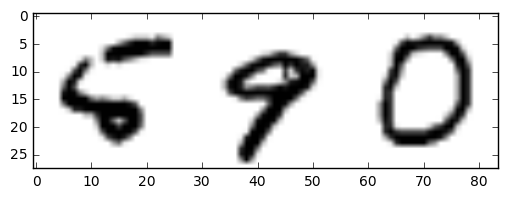

[  3.38023150e-04   9.77633317e-06   1.06269516e-04   1.67895610e-06
   4.59283765e-04   2.96763092e-01   8.63779522e-03   7.29255271e-06
   1.10866511e-02   1.61738746e-04   1.69845480e-05   5.49016939e-08
   4.04211323e-06   1.87581929e-06   2.92698061e-03   6.55223721e-06
   2.35260595e-05   3.45266162e-04   9.03821201e-05   3.46320629e-01
   3.32668096e-01   7.38595602e-08   3.19008791e-06   1.71503729e-07
   2.69613042e-06   2.88306569e-06   1.23077853e-05   1.41462397e-06
   1.94948413e-07   1.05718902e-06]
(9997, 28, 84, 1)
(28, 84, 1)
3


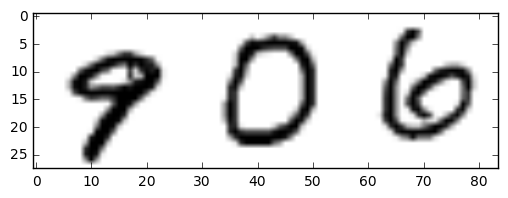

[  6.06255981e-06   5.58618360e-08   4.12361771e-07   1.10493638e-05
   1.90524489e-03   1.30731991e-04   2.20503625e-05   5.74862445e-03
   9.12857504e-05   3.16912323e-01   3.14643323e-01   8.11746581e-09
   7.54419659e-07   4.06563210e-08   1.77587310e-07   1.61044966e-06
   6.17845581e-06   2.92560031e-07   7.93556012e-07   4.65143216e-07
   4.66958694e-02   5.11046743e-08   8.63843411e-07   2.68694606e-07
   2.41530943e-05   1.81662035e-04   3.13555509e-01   2.40171374e-07
   5.39682151e-05   5.99570149e-06]


In [78]:
nb_digits = 3
nb_epoch = 30
(X_train, y_train), (X_test, y_test), input_shape = getTrainData(nb_digits)
#display_digit(10, nb_digits, X_train)
train_model1(X_train, y_train, X_test, y_test, input_shape, nb_epoch)

In [81]:
def train_model2(Xtrain, yTrain, XTest, yTest, inpShape, nb_epoch):
    print('X_train shape:', Xtrain.shape)
    print('Y_train shape:', y_train.shape)
    print('yTest shape:', yTest.shape)
    
    batch_size = 128
    nb_filters = 100
    pool_size = (2, 2)
    kernel_size = (5, 5)

    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='valid', input_shape=inpShape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))

    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))

    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))

    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))

#    model.add(MaxPooling2D(pool_size=pool_size))
#    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(yTrain.shape[1]))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    model.fit(Xtrain, yTrain, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(XTest, yTest))
    score = model.evaluate(XTest, yTest, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    predictions = model.predict(XTest[0:3])
    for i in range(0,3):
        display_digit(i, yTest.shape[1]/10, XTest)
        print(predictions[i])


(59997, 28, 84) (9997, 28, 84)
X_train shape: (59997, 28, 84, 1)
Y_train shape: (59997, 30)
yTest shape: (9997, 30)
Train on 59997 samples, validate on 9997 samples
Epoch 1/6
59997/59997 [==============================] - 10984s - loss: 6.0223 - acc: 0.2871 - val_loss: 3.8344 - val_acc: 0.2869
Epoch 2/6
59997/59997 [==============================] - 10871s - loss: 4.0021 - acc: 0.3326 - val_loss: 3.4935 - val_acc: 0.3004
Epoch 3/6
59997/59997 [==============================] - 11031s - loss: 3.6084 - acc: 0.3349 - val_loss: 3.4007 - val_acc: 0.3770
Epoch 4/6
59997/59997 [==============================] - 11762s - loss: 3.4414 - acc: 0.3407 - val_loss: 3.4327 - val_acc: 0.3451
Epoch 5/6
59997/59997 [==============================] - 10991s - loss: 3.4787 - acc: 0.3450 - val_loss: 3.3712 - val_acc: 0.2685
Epoch 6/6
59997/59997 [==============================] - 10731s - loss: 3.4014 - acc: 0.3382 - val_loss: 3.3887 - val_acc: 0.3624
Test score: 3.38867814288
Test accuracy: 0.362408722632

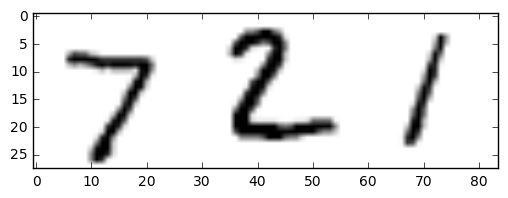

[  6.56709658e-14   2.57918839e-14   1.88904361e-12   3.03836040e-10
   1.49507969e-13   2.11008901e-14   3.66180856e-15   3.33630770e-01
   4.71406837e-11   1.67881584e-10   4.07808485e-14   2.82852994e-12
   3.38029325e-01   2.80566317e-11   1.25926557e-15   6.15701171e-11
   2.32391684e-09   2.99639827e-11   2.56032928e-09   9.06245981e-11
   2.15032815e-14   3.28339905e-01   9.89687390e-13   5.34570409e-11
   1.91214855e-13   5.99529757e-13   1.65370512e-11   1.10081208e-13
   2.00761150e-08   2.45629100e-10]
(9997, 28, 84, 1)
(28, 84, 1)
3


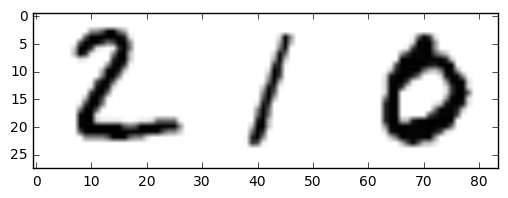

[  3.47750499e-15   2.75505521e-11   3.38530451e-01   1.41577483e-12
   2.30628121e-11   3.84974164e-10   1.07868026e-09   1.54326541e-12
   3.23721789e-13   7.86957901e-13   3.39152073e-13   3.32253158e-01
   1.38605363e-10   1.29031811e-11   4.45975146e-14   5.88786572e-12
   1.64748992e-14   3.75429288e-13   7.94896440e-12   9.58228982e-11
   3.29216391e-01   4.51322532e-14   4.77595116e-11   1.00979251e-11
   5.72018182e-13   2.92273428e-11   7.65503329e-13   5.62366289e-13
   3.02035697e-12   2.03284178e-11]
(9997, 28, 84, 1)
(28, 84, 1)
3


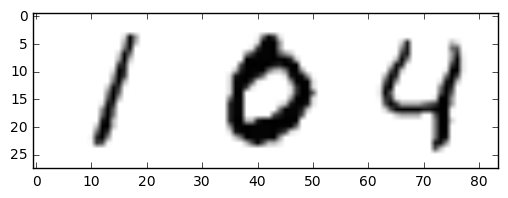

[  1.87474461e-06   3.30371678e-01   2.34581671e-06   1.75041134e-06
   1.29390315e-07   2.14510165e-09   4.22059330e-08   6.85705345e-06
   5.64103360e-08   3.80235804e-07   3.33877951e-01   3.65110076e-08
   3.26640830e-08   8.42912868e-07   1.70463423e-07   9.25121881e-08
   7.00467426e-05   4.26742126e-08   3.40201098e-07   1.36824468e-07
   3.77840088e-08   3.36491382e-07   4.97660210e-07   4.82358686e-08
   3.35661650e-01   6.03262436e-08   7.28016630e-07   6.62696038e-07
   5.13554852e-08   1.15793694e-06]


In [83]:
nb_digits = 3
nb_epoch = 6
(X_train, y_train), (X_test, y_test), input_shape = getTrainData(nb_digits)
#display_digit(10, nb_digits, X_train)
train_model2(X_train, y_train, X_test, y_test, input_shape, nb_epoch)

(59997, 28, 84) (9997, 28, 84)
X_train shape: (1000, 28, 84, 1)
Y_train shape: (59997, 30)
yTest shape: (9997, 30)
Train on 1000 samples, validate on 9997 samples
Epoch 1/50
1000/1000 [==============================] - 885s - loss: 10.1497 - acc: 0.0440 - val_loss: 15.2646 - val_acc: 0.1203
Epoch 2/50
1000/1000 [==============================] - 741s - loss: 11.0449 - acc: 0.0670 - val_loss: 9.4828 - val_acc: 0.1370
Epoch 3/50
1000/1000 [==============================] - 743s - loss: 9.5342 - acc: 0.1040 - val_loss: 8.7756 - val_acc: 0.1262
Epoch 4/50
1000/1000 [==============================] - 741s - loss: 9.1775 - acc: 0.1390 - val_loss: 8.2127 - val_acc: 0.2095
Epoch 5/50
1000/1000 [==============================] - 741s - loss: 8.7987 - acc: 0.1560 - val_loss: 8.6580 - val_acc: 0.1556
Epoch 6/50
1000/1000 [==============================] - 739s - loss: 8.5943 - acc: 0.1780 - val_loss: 8.3062 - val_acc: 0.1175
Epoch 7/50
1000/1000 [==============================] - 852s - loss: 8.2

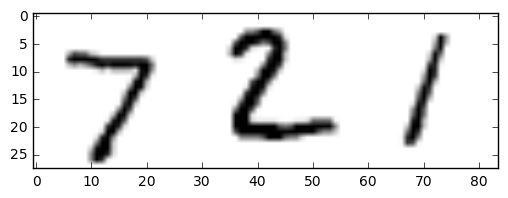

[  7.25603662e-03   5.03877469e-04   1.10664091e-03   1.06558611e-03
   4.71563253e-04   2.77785165e-03   2.52561690e-03   4.41245675e-01
   5.49124146e-04   2.59214919e-03   2.20430503e-03   1.72539207e-03
   1.21007837e-01   6.45656721e-04   3.48215341e-04   2.71899300e-03
   1.53985266e-02   5.35644591e-04   9.63725056e-03   2.47487100e-03
   2.76468066e-03   3.66951019e-01   2.67424999e-04   2.95306207e-04
   1.72945950e-03   3.69827467e-04   7.45989819e-05   5.26276836e-03
   3.60404444e-03   1.89002091e-03]
(9997, 28, 84, 1)
(28, 84, 1)
3


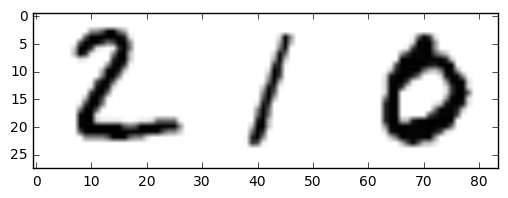

[  4.11524996e-03   2.09043548e-03   2.69784480e-01   4.50370688e-04
   6.11396157e-04   1.27997121e-03   1.68729806e-03   3.45021021e-04
   3.42200114e-03   8.66934133e-05   4.90026199e-04   4.01069939e-01
   8.20781861e-05   5.25631360e-04   2.47467426e-04   1.75767840e-04
   7.49752915e-04   2.52618542e-04   1.20901321e-04   7.32911751e-04
   3.07408214e-01   1.25897268e-03   5.88543946e-04   7.24679499e-04
   1.66881437e-05   5.28014614e-04   9.53100738e-04   9.33908304e-05
   3.51509880e-05   7.30132670e-05]
(9997, 28, 84, 1)
(28, 84, 1)
3


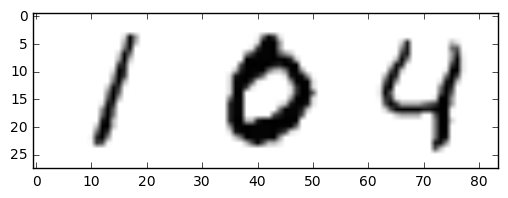

[  3.60334595e-03   1.07960731e-01   3.00884526e-03   2.20195856e-03
   1.27697748e-03   1.02243677e-03   2.19543534e-03   2.29103654e-03
   7.02013867e-03   5.99223480e-04   4.25291985e-01   3.10323288e-04
   1.93239597e-03   1.84824318e-03   1.51317474e-03   6.39453123e-04
   2.19742837e-03   3.21898470e-03   3.66389891e-03   6.93518342e-03
   4.92587127e-03   1.15034229e-03   1.35971734e-03   8.48536962e-04
   3.75433415e-01   5.98222855e-03   1.15358867e-02   8.61169863e-03
   6.44133484e-04   1.07768672e-02]


In [84]:
nb_digits = 3
nb_epoch = 50
(X_train, y_train), (X_test, y_test), input_shape = getTrainData(nb_digits)
#Trying to see if I can overfit the data on a subset (1000 images)
train_model2(X_train[:1000], y_train[:1000], X_test, y_test, input_shape, nb_epoch)

In [2]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.